## Measuring the cosmological parameters spatial distribution.



### Martín de los Rios, Mariano Dominguez

In [9]:
#Funciones necesarias para correr todo
#Feature selection por bineado
#{{{
feature.select<-function(x,y,n.feat,x.min,x.max){
  #xbin=(max(x)-min(x))/(n.feat)
  xbin=(x.max-x.min)/(n.feat)

  y.feat<-1:n.feat
  x.feat<-1:n.feat

  dx=0.00001 #Es para evitar que el maximo se quede afuera por redondeo de la compu
  for(i in 1:n.feat){
    #x.feat[i]=min(x)+xbin*(2*(i-1)+1)/2
    x.feat[i]=x.min+xbin*(2*(i-1)+1)/2
    xmin=x.feat[i]-xbin/2
    xmax=x.feat[i]+xbin/2
    y.aux<-y[which(x>=(xmin-dx) & x<=(xmax+dx))]
    if(length(y.aux) > 1){
      y.feat[i]=mean(y.aux)
    } else if (length(y.aux) == 1){
      y.feat[i]= y.aux[1]
    } else if (length(y.aux) == 0){
      y.feat[i]= -9999
    }
  }

  for(i in 1:n.feat){
    if(y.feat[i] == -9999){
      ysup=-9999
      yinf=-9999
      for(j in 1:(n.feat-1)){
        if(ysup<0 & (i+j) <= n.feat){
          if(y.feat[i+j] > 0){ysup=y.feat[i+j]}
        }
        if(yinf<0 & (i-j) > 0){
          if(y.feat[i-j] > 0){yinf=y.feat[i-j]}
        }
      }
      y.feat[i]=(ysup+yinf)/2
    }
  }

  y.feat[which(y.feat < 0)]=0

  mat<-data.frame(x.feat,y.feat)
  return(mat)
}
#}}}
#Feature selection por bineado (cmb)
#{{{
feature.select.cmb<-function(x,y,n.feat){
  xbin=(max(x)-min(x))/(n.feat)

  y.feat<-1:n.feat
  x.feat<-1:n.feat

  for(i in 1:n.feat){
    x.feat[i]=min(x)+xbin*(2*(i-1)+1)/2
    xmin=x.feat[i]-xbin/2
    xmax=x.feat[i]+xbin/2
    y.feat[i]=mean(y[which(x>=xmin & x<xmax)])
  }

  mat<-data.frame(x.feat,y.feat)
}
#}}}

#PCA_mat
#{{{
PCA_mat<-function(dat){
  mat_cov<-cov(dat)
  eig<-eigen(mat_cov)
  mat_cb<-solve(eig$vectors) 

  return(mat_cb)
}
#}}}

#validacion
#{{{
validacion<-function(datos,datos_aux){

  fl=0
  datos_aux<-subset(datos_aux,datos_aux$y.feat > 0)
  for(i in 1:length(datos_aux$y.feat)){
    if((datos_aux$y.feat[i] < min(datos[,4+i]) | (datos_aux$y.feat[i] > max(datos[,4+i])))){fl=1}
  }

  return(fl)
}
#}}}
#validacion1
#{{{
validacion1<-function(datos,datos_aux){

  flags<-1:length(datos_aux$y.feat)
  flags[]=0
  for(i in 1:length(datos_aux$y.feat)){
    if((datos_aux$y.feat[i] < min(datos[,4+i]) | (datos_aux$y.feat[i] > max(datos[,4+i])))){
      flags[i]=1
    }
  }

  return(flags)
}
#}}}
#rename
#{{{
rename<-function(trainset){

  name1<-colnames(trainset)[1]
  trainset_aux<-trainset[,-1]

  name<-1:(length(trainset)-1)
  for(i in 1:length(name)){
    name[i]<-paste('X',toString(i),sep='')
  }
 
  name<-c(name1,name)
  colnames(trainset)<-name
  return(trainset)
}
#}}}
#rename1
#{{{
rename1<-function(trainset){

  trainset_aux<-trainset

  name<-1:length(trainset_aux)
  for(i in 1:length(trainset_aux)){
    name[i]<-paste('X',toString(i),sep='')
  }
 
  colnames(trainset)<-name
  return(trainset)
}
#}}}
library('latex2exp')
library('caret')

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



### Machine learning techniques in Astronomy.

In [56]:
dat<-read.table('colors_training_set.csv',sep=',',header=T)
vec<-c('u_g','g_r','r_i','i_z','clase')
colnames(dat)<-vec
str(dat)

'data.frame':	6930 obs. of  5 variables:
 $ u_g  : num  0.834 1.359 1.659 2.169 2.208 ...
 $ g_r  : num  0.226 0.526 0.629 0.888 1.004 ...
 $ r_i  : num  0.0416 0.1647 0.2196 0.2986 0.3465 ...
 $ i_z  : num  0.1505 0.0692 0.121 0.1705 0.2208 ...
 $ clase: Factor w/ 3 levels "qso","rrl","star": 3 3 3 3 3 3 3 3 3 3 ...


In [57]:
print(summary(dat))

      u_g               g_r               r_i                i_z          
 Min.   :-0.9872   Min.   :-0.6748   Min.   :-0.87247   Min.   :-0.99843  
 1st Qu.: 0.8595   1st Qu.: 0.1729   1st Qu.: 0.04671   1st Qu.:-0.01119  
 Median : 1.1537   Median : 0.3413   Median : 0.13591   Median : 0.06187  
 Mean   : 1.2865   Mean   : 0.4806   Mean   : 0.24800   Mean   : 0.11516  
 3rd Qu.: 1.7090   3rd Qu.: 0.7965   3rd Qu.: 0.31760   3rd Qu.: 0.21869  
 Max.   : 4.4834   Max.   : 1.9708   Max.   : 2.78331   Max.   : 1.47968  
  clase     
 qso : 988  
 rrl : 998  
 star:4944  
            
            
            


In [16]:
#Load the Random Forest package
library('randomForest')

#Split the data into test and train set
ind<-sample(x=1:length(dat$u_g),replace=F,size = 6000)
train_set<-dat[ind,]
test_set<-dat[-ind,]

#We train a Machine Learning model
model<-randomForest(clase~., data=train_set)

#We predict the class for the data in the test set
predicted_class<-predict(model,newdata = test_set)

In [17]:
confusionMatrix(data = predicted_class,reference = test_set$clase)$table

          Reference
Prediction qso rrl star
      qso   95   0   28
      rrl    1 119   15
      star  25   5  642

In [6]:
#Load the packages that we will use
library('CosmoPhotoz') #This package contain the data
library('kernlab') #This package contain a Support Vector Machine implementation
library('randomForest') #This package contain a Random Forest implementation

#We load the train and test set
data(PHAT0train)
data(PHAT0test)

In [7]:
summary(PHAT0train)

    redshift            up              gp              rp       
 Min.   :0.0200   Min.   :17.50   Min.   :15.89   Min.   :15.15  
 1st Qu.:0.2400   1st Qu.:23.50   1st Qu.:23.01   1st Qu.:22.34  
 Median :0.4000   Median :24.17   Median :23.75   Median :23.15  
 Mean   :0.4239   Mean   :24.07   Mean   :23.49   Mean   :22.82  
 3rd Qu.:0.5800   3rd Qu.:24.66   3rd Qu.:24.20   3rd Qu.:23.61  
 Max.   :2.1800   Max.   :28.69   Max.   :26.42   Max.   :24.08  
       ip              zp              Y               J        
 Min.   :14.75   Min.   :14.49   Min.   :14.26   Min.   :14.11  
 1st Qu.:21.93   1st Qu.:21.72   1st Qu.:21.52   1st Qu.:21.26  
 Median :22.72   Median :22.54   Median :22.40   Median :22.20  
 Mean   :22.46   Mean   :22.30   Mean   :22.15   Mean   :21.94  
 3rd Qu.:23.27   3rd Qu.:23.13   3rd Qu.:23.03   3rd Qu.:22.85  
 Max.   :24.10   Max.   :23.88   Max.   :23.90   Max.   :23.68  
       H               K             IRAC_1          IRAC_2     
 Min.   :13.88   M

In [8]:
#We train a RF and SVM model
rf<-randomForest(redshift~.,data=PHAT0train)
svm<-ksvm(redshift~.,data=PHAT0train)

#We make prediction for the data in the test set

photoz_rf<-predict(rf,newdata = PHAT0test)
photoz_svm<-predict(svm,newdata = PHAT0test)

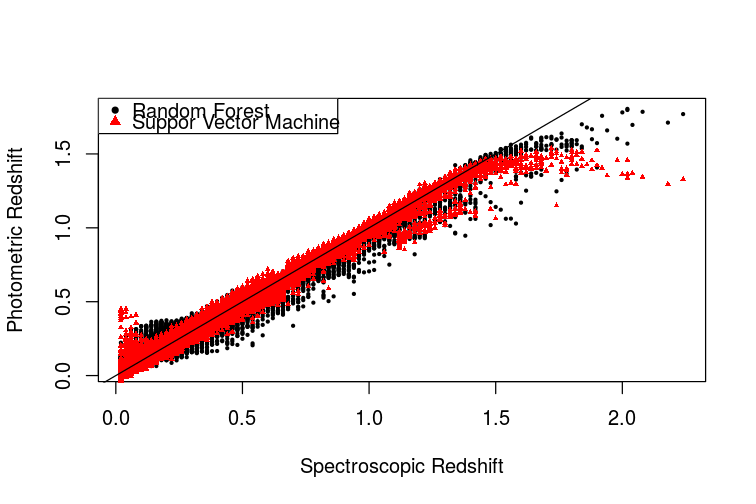

In [17]:
#Now we must compare the predictions of the two models

options(repr.plot.width=6.3, repr.plot.height=4.2)
plot(PHAT0test$redshift,photoz_rf, pch=20,cex=0.5,col='black',xlab='Spectroscopic Redshift',ylab='Photometric Redshift')
points(PHAT0test$redshift,photoz_svm, pch=17,cex=0.5,col='red')
abline(a=0,b=1)
legend('topleft',c('Random Forest','Suppor Vector Machine'),pch=c(20,17),col=c('black','red'))

Bogus-Real Clasiffication of transitors in optical images

<center>
<img src='bruno2.png' width='600'>

<center>
<img src='bruno1.png' width='900'>

Galaxy clusters dynamical status clasification using Random Forest (MeSsI).

<center>
<img src='resu.png' width='600'>

### Basic concepts of Cosmology.

Homogeneous and isotropic Universe -> FRW Metric

$ds^{2}=dt^{2}-a^{2}(t)[\frac{dr^{2}}{1-kr^{2}}+r^{2}(d \theta^{2}+sin^{2} \theta d \phi^{2})] $

$(\frac{H}{H_{0}})^{2}=\Omega_{rad}a^{-4}+\Omega_{m}a^{-3}+\Omega_{\Lambda}-Kc^{2}a^{-2}$

|||
|:------|------:|
|<img style="float: left;" src='supernovas.png' width=480>|<img style="float: right;" src='planck.png' width=610>|
|*Supernovas JLA (Carvalho & Marques 2015 (1512.07869))*|*Cosmic Microwave Background (Planck Collaboration 2015 (1502.01589))*|

<center>
<img align='center' src=bananas2.png width=700>
*(Betoule et al. 2014 (1401.4064))*

<tiny>
Latest Planck Results (Planck Collaboration (1502.01589))

$\Omega_{m}h^{2} = 0.1197 \pm 0.0022$  $\Omega_{k} = -0.0052 \pm 0.049$ $\Omega_{b}h^{2} = 0.0226 \pm 0.00023$ $H_{0} = 67.31 \pm 0.96$

</tiny>

### problems

* Riess et al. 2016 (1604.01424) find a local value of $H_{0}=73.24 \pm 1.74$
* Buchert et al. 2016 (1505.07800), Kolb et al. 2006 (0506534) find that the small scales inhomogeneities can backreactions effects that may reproduce the effect of a cosmological constant.

|||
|:------|------:|
|<img style="float: left;" src='matter.png' width=600>|<img style="float: right;" src='hubble.png' width=600>|
*Angular Distribution of the relative variance of the cosmological parameters measured with supernova data (Carvalho & Marques (1512.07869)).*

#### Problems
* Estimate the angular distribution using supernova data -> Lot of pixel with very few data points
* In order to estimate the cosmological parameters using CMB information, you need to use MCMC  -> Very time-consuming 

### Estimating the cosmological parameters using Machine Learning.


#### Solutions

* The CMB information is distributed evenly along the sky (descounting the galactic foreground).
* Once you have trained your machine learning algorithm, the estimation of the cosmological parameters is very fast.

|||
|:------|------:|
|<img style="float: left;" src='fig1_nueva.png' width=550>|<img style="float: right;" src='fig2_nueva.png' width=550>|
<tiny> *Simulated Power Specturm and Hubble diagrams that will be used as training and test samples.* </tiny>

<center>
<img src='fig3.png' width=600>

<center>
<img src='fig4.png' width=600>

<center>
<img src='fig5.png' width=600>

### Angular Distribution of the Cosmological Parameters.

* Planck (*Rogers et al. 2016 (1601.01322)*)+ Sn tipo Ia (*Betoule et al. 2014 (1401.4064)*)
* Support Vector Machine
* [Healpix (Hierarchical Equal Area isoLatitude Pixelization)](http://healpix.jpl.nasa.gov/index.shtml)

|||
|:------|------:|
|<img style="float: left;" src='map-om-192-pix.png' width=450>|<img style="float: right;" src='map-omk-192-pix.png' width=450>|
|<img style="float: left;" src='map-omb-192-pix.png' width=450>|<img style="float: right;" src='map-h-192-pix.png' width=450>|

<center>
<img src='comparaciones.png' width=650>

## Conclutions and Future Work.

* We developed a machine learning technique that estimate the cosmological parameters in a more efficient way than the standar approuch and allow us to measure the angular distribution of this parameters.
* This method can be easily extended to use more cosmological information (BAO, correlation function, SZ emission, etc.).
* We do not found statistically significant departures from what is expected in an homogeneous and isotropic universe, with the possible exception of a bi-model $H_{0}$ distribution.

* We will study the correlations between the local cosmological parameters and the large scale structure of the universe (Voids, Clusters, Filaments).
* We will extend the parameters space and add polarization information in a forthcoming work.

<center>
    <img src='thankyou.png' width=850>